In [1]:
import sys

sys.path.append('../../notebooks')
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from notebooks.core import constants
from notebooks.core import model_utils

In [2]:
df = pd.read_json('../../data/translated/emotions/equalized_emotions_dataset_pl.json')
df

,text,emotions,text_pl
0,i feel totally greedy,anger,Czuję się całkowicie chciwy
1,i feel so overwhelmed with emotions,fear,Czuję się tak przytłoczony emocjami
2,i didnt feel the g force effect i am stunned i...,surprise,Nie czułem efektu siły g Jestem oszołomiony Po...
3,ive just got to tell you all that im feeling r...,anger,ive just got to tell you all that I feel Racze...
4,i told you i was sorry you were feeling frustr...,anger,"Powiedziałem ci, że przepraszam, że czujesz si..."
...,...,...,...
39995,im feeling quite generous lately as ive been w...,joy,"czuję się ostatnio dość hojny, ponieważ pracuj..."
39996,i feel like some of the characters dont deserv...,love,"Czuję, że niektóre postacie nie zasługują na w..."
39997,im feel fear within my bones that cant be shak...,fear,"Czuję strach w moich kościach, którego nie moż..."
39998,ive been feeling more creative and less like a...,joy,Czułem się bardziej kreatywny i mniej jak czys...


In [3]:
df = df.drop(columns=['text'])
df

,emotions,text_pl
0,anger,Czuję się całkowicie chciwy
1,fear,Czuję się tak przytłoczony emocjami
2,surprise,Nie czułem efektu siły g Jestem oszołomiony Po...
3,anger,ive just got to tell you all that I feel Racze...
4,anger,"Powiedziałem ci, że przepraszam, że czujesz si..."
...,...,...
39995,joy,"czuję się ostatnio dość hojny, ponieważ pracuj..."
39996,love,"Czuję, że niektóre postacie nie zasługują na w..."
39997,fear,"Czuję strach w moich kościach, którego nie moż..."
39998,joy,Czułem się bardziej kreatywny i mniej jak czys...


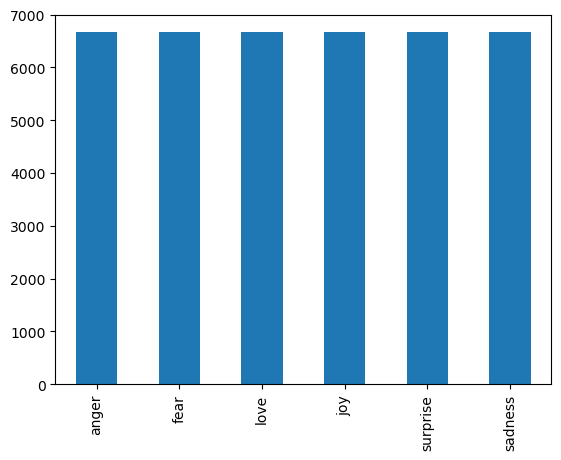

In [4]:
data = df["emotions"]
data.value_counts().plot.bar()
plt.show()

In [5]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

In [6]:
df = df.replace({"emotions": ordered_class_labels})

In [7]:
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
raw_dataset

Dataset({
    features: ['emotions', 'text_pl'],
    num_rows: 40000
})

In [8]:
from transformers import AutoTokenizer

checkpoint = "dkleczek/bert-base-polish-uncased-v1"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [9]:
def tokenize_function(example):
    return tokenizer(example["text_pl"], truncation=True)


tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [10]:
# Train set: 80%, Validation set: 10%, Test set: 10%
tokenized_train_dataset, tokenized_val_dataset, tokenized_test_dataset = model_utils.split_train_val_test(
    tokenized_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5,
    shuffle=True,
    seed=42)

In [13]:
tokenized_test_dataset['text_pl'][:5]

['Myślę, że to prawdopodobnie dobry pomysł, wciąż czuję się trochę niepewnie, aby odpuścić',
 'Wciąż czuję, że wciąż boję się tego uczucia i wciąż powraca i wciąż mnie przeraża, przeraża mnie, boję się, boję się.',
 'Ostatnio czuję się dość nostalgicznie, ale to miłe uczucie i lubię patrzeć wstecz na te wspomnienia',
 'Jestem pod wrażeniem, że udało mi się wyciągnąć dwa pełne zdania.',
 'Nie sądzę, że wymieniłem choć jeden uśmiech z nieznajomym na ulicy, który wciąż wydaje mi się dziwny.']

In [19]:
from transformers import DataCollatorWithPadding

columns = ["attention_mask", "input_ids", "token_type_ids"]
label_cols = ["emotions"]
batch_size = 8
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = model_utils.convert_to_tf_dataset(tokenized_train_dataset, columns, label_cols, data_collator,
                                                     batch_size)
tf_val_dataset = model_utils.convert_to_tf_dataset(tokenized_val_dataset, columns, label_cols, data_collator,
                                                   batch_size)
tf_test_dataset = model_utils.convert_to_tf_dataset(tokenized_test_dataset, columns, label_cols, data_collator,
                                                    batch_size)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [20]:
# Model parameters
training_number = 5
model_name = "emotions_pl_bert"

training_name = f"training_{training_number}"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
figures_dir = f"../../documentation/models/{model_name}/figures"
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)

In [21]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [22]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [23]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6, from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [25]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/10
4000/4000 [==============================] - 321s 77ms/step - loss: 0.5872 - accuracy: 0.8036 - val_loss: 0.4027 - val_accuracy: 0.8662

Epoch 00001: saving model to ../../training_checkpoints\emotions_pl_bert\training_5\cp-0001.ckpt
Epoch 2/10
4000/4000 [==============================] - 305s 76ms/step - loss: 0.3483 - accuracy: 0.8795 - val_loss: 0.4080 - val_accuracy: 0.8630

Epoch 00002: saving model to ../../training_checkpoints\emotions_pl_bert\training_5\cp-0002.ckpt
Epoch 3/10
4000/4000 [==============================] - 301s 75ms/step - loss: 0.2567 - accuracy: 0.9078 - val_loss: 0.4487 - val_accuracy: 0.8530

Epoch 00003: saving model to ../../training_checkpoints\emotions_pl_bert\training_5\cp-0003.ckpt
Epoch 4/10
4000/4000 [==============================] - 291s 73ms/step - loss: 0.1875 - accuracy: 0.9323 - val_loss: 0.4541 - val_accuracy: 0.8658

Epoch 00004: saving model to ../../training_checkpoints\emotions_pl_bert\training_5\cp-0004.ckpt


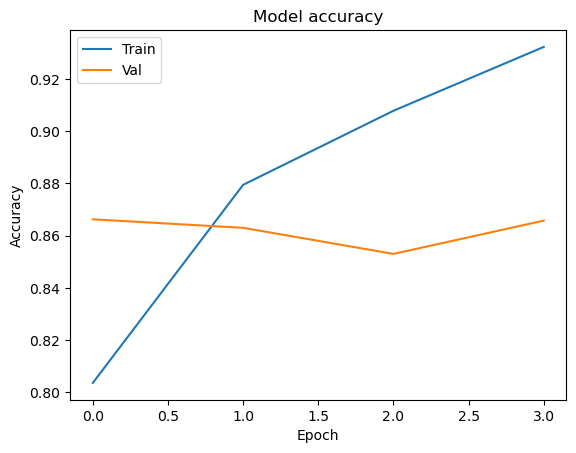

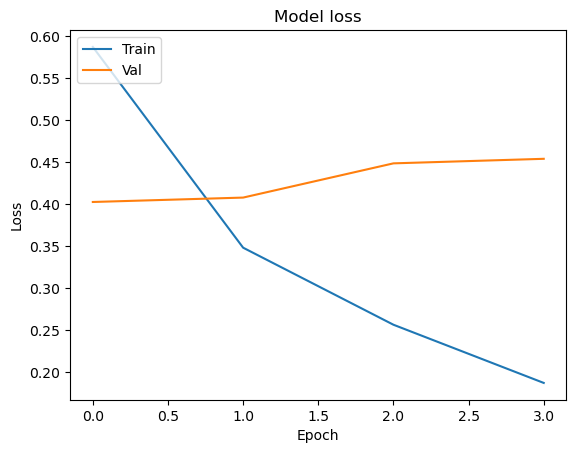

In [26]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [27]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

In [28]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number, saved_models_dir=constants.SAVED_MODEL_LOCATION, default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ../../trained_models\emotions_pl_bert_5\1\assets


INFO:tensorflow:Assets written to: ../../trained_models\emotions_pl_bert_5\1\assets


In [29]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=batch_size)

500/500 [==============================] - 14s 27ms/step - loss: 0.4136 - accuracy: 0.8615


[0.4136037230491638, 0.8615000247955322]

In [30]:
class_preds = model_utils.get_class_preds(model, tf_test_dataset)

In [31]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset['emotions'],
    class_preds=class_preds,
    average='micro'
)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.8615
Recall score:  0.8615
F1 score:  0.8615


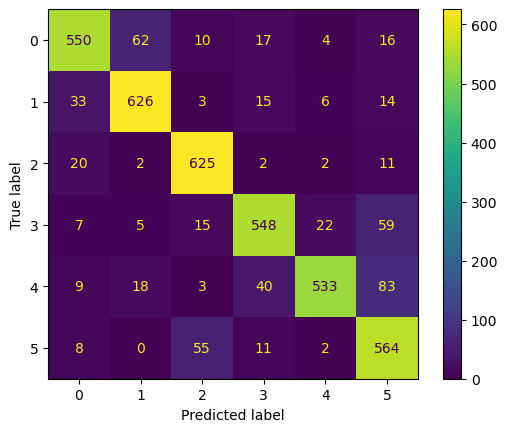

In [32]:
model_utils.plot_and_save_conf_matrix(class_actual=tokenized_test_dataset['emotions'],
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [33]:
model_utils.print_incorrectly_predicted_texts(texts=raw_dataset['text_pl'],
                                              class_actual=raw_dataset['emotions'],
                                              class_preds=class_preds)


            BAD PREDICTION:
            - INDEX: 2
            - TEXT: Nie czułem efektu siły g Jestem oszołomiony Poszedłem na tę przejażdżkę z moimi przyjaciółmi
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 2
            

            BAD PREDICTION:
            - INDEX: 3
            - TEXT: ive just got to tell you all that I feel Raczej niecierpliwy
            - PREDICTED VALUE: 2
            - CORRECT VALUE: 4
            

            BAD PREDICTION:
            - INDEX: 4
            - TEXT: Powiedziałem ci, że przepraszam, że czujesz się sfrustrowany i zapytałem, czy myślisz, że krzyk zmieni moje zdanie
            - PREDICTED VALUE: 2
            - CORRECT VALUE: 4
            

            BAD PREDICTION:
            - INDEX: 5
            - TEXT: Czuję się nieco niepewnie prosząc o pomoc w pomaganiu mi w finansowaniu tej podróży, ponieważ wydaje się to bardzo pobłażliwą rzeczą, którą można poprosić o pomoc.
            - PREDICTED VALUE: 1
            - C

In [34]:
tokenized_test_dataset

Dataset({
    features: ['emotions', 'text_pl', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4000
})

In [62]:
test_df = pd.DataFrame(
    list(zip(tokenized_test_dataset['text_pl'], tokenized_test_dataset['emotions'], class_preds)),
    columns=['text_pl', 'emotions', 'prediction'])
test_df

,text_pl,emotions,prediction
0,"Myślę, że to prawdopodobnie dobry pomysł, wcią...",5,5
1,"Wciąż czuję, że wciąż boję się tego uczucia i ...",5,5
2,"Ostatnio czuję się dość nostalgicznie, ale to ...",1,1
3,"Jestem pod wrażeniem, że udało mi się wyciągną...",2,2
4,"Nie sądzę, że wymieniłem choć jeden uśmiech z ...",2,2
...,...,...,...
3995,Czuję się wspaniale zrelaksowany w wyniku,0,0
3996,Czuję się zrzędliwy teraz fani futbolu obudzil...,4,4
3997,"są związani z tym, co robią, pomimo tego, jak ...",0,5
3998,"Czuję i będziesz zaskoczony zmianami, które na...",2,2


In [63]:
def map_token_counts(row):
    return len(row['text_pl'].split())

def map_count_belonging(row, divider):
    int_division_result = int(row['token_count'] / divider) + 1
    lower_boundary = divider * int_division_result - divider
    upper_boundary = divider * int_division_result - 1
    return f"{lower_boundary}-{upper_boundary}"

def map_correctly_predicted(row):
    return int(row['emotions'] == row['prediction'])


test_df['token_count'] = test_df.apply(lambda row: map_token_counts(row), axis=1)
test_df['count_belonging'] = test_df.apply(lambda row: map_count_belonging(row, divider=6), axis=1)
test_df['correctly_predicted'] = test_df.apply(lambda row: map_correctly_predicted(row), axis=1)
test_df

,text_pl,emotions,prediction,token_count,count_belonging,correctly_predicted
0,"Myślę, że to prawdopodobnie dobry pomysł, wcią...",5,5,13,12-17,1
1,"Wciąż czuję, że wciąż boję się tego uczucia i ...",5,5,21,18-23,1
2,"Ostatnio czuję się dość nostalgicznie, ale to ...",1,1,16,12-17,1
3,"Jestem pod wrażeniem, że udało mi się wyciągną...",2,2,11,6-11,1
4,"Nie sądzę, że wymieniłem choć jeden uśmiech z ...",2,2,17,12-17,1
...,...,...,...,...,...,...
3995,Czuję się wspaniale zrelaksowany w wyniku,0,0,6,6-11,1
3996,Czuję się zrzędliwy teraz fani futbolu obudzil...,4,4,12,12-17,1
3997,"są związani z tym, co robią, pomimo tego, jak ...",0,5,22,18-23,0
3998,"Czuję i będziesz zaskoczony zmianami, które na...",2,2,9,6-11,1


In [64]:
test_df = test_df.drop(test_df[test_df.token_count > 41].index)

In [65]:
test_df = test_df.sort_values(by=['token_count']).reset_index(drop=True)

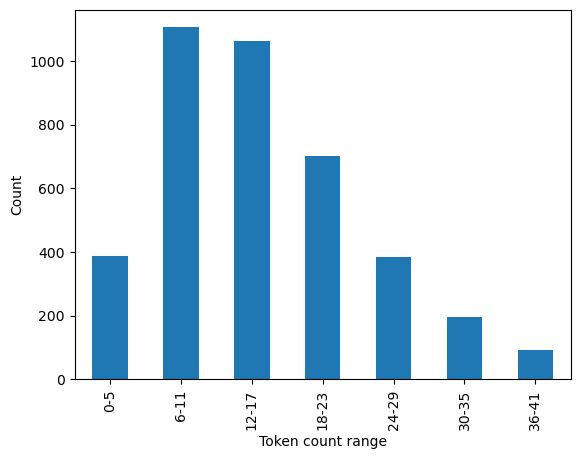

In [66]:
data = test_df['count_belonging']
data.value_counts(sort=False).plot.bar()
plt.xlabel('Token count range')
plt.ylabel('Count')
plt.savefig(os.path.join(figures_dir, f'{training_name}_counts_per_range.png'))
plt.show()

In [67]:
range_to_valid_predictions_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0, '30-35': 0, '36-41': 0}
range_to_element_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0, '30-35': 0, '36-41': 0}
range_to_pred_accuracy_dict = {'0-5': 0., '6-11': 0., '12-17': 0., '18-23': 0., '24-29': 0., '30-35': 0., '36-41': 0.}

In [68]:
for _, row in test_df.iterrows():
    count_belonging = row['count_belonging']

    range_to_element_count_dict[count_belonging] = range_to_element_count_dict[count_belonging] + 1

    if row['correctly_predicted']:
        range_to_valid_predictions_count_dict[count_belonging] = range_to_valid_predictions_count_dict[count_belonging] + 1

for key in range_to_pred_accuracy_dict.keys():
    range_to_pred_accuracy_dict[key] = range_to_valid_predictions_count_dict[key] / range_to_element_count_dict[key]

print("Correct predictions count: ", range_to_valid_predictions_count_dict)
print("Element count: ", range_to_element_count_dict)
print("Accuracies: ", range_to_pred_accuracy_dict)

Correct predictions count:  {'0-5': 334, '6-11': 969, '12-17': 936, '18-23': 596, '24-29': 321, '30-35': 158, '36-41': 74}
Element count:  {'0-5': 386, '6-11': 1106, '12-17': 1064, '18-23': 702, '24-29': 383, '30-35': 197, '36-41': 93}
Accuracies:  {'0-5': 0.8652849740932642, '6-11': 0.8761301989150091, '12-17': 0.8796992481203008, '18-23': 0.8490028490028491, '24-29': 0.8381201044386423, '30-35': 0.8020304568527918, '36-41': 0.7956989247311828}


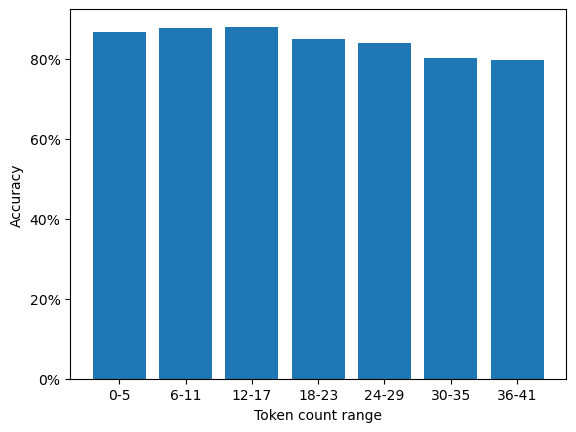

In [69]:
import matplotlib.ticker as mtick

plt.bar(['0-5', '6-11', '12-17', '18-23', '24-29', '30-35', '36-41'], [val for val in range_to_pred_accuracy_dict.values()])
plt.xlabel('Token count range')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig(os.path.join(figures_dir, f'{training_name}_accuracies_per_range.png'))
plt.show()